In [1]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ensembles"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# 7.1 투표기반 분류기

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X,y = make_moons(n_samples=500,noise=0.3,random_state=42)
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=42)


#### 하드보팅 (예측을 모아 가장 많은 숫자를 결과로)

In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.svm import SVC

log_clf = LogisticRegression(solver="lbfgs",random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100,random_state=42)
svm_clf = SVC(gamma="scale", random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr',log_clf),('rf',rnd_clf),("svc",svm_clf)],
    voting="hard"
)

In [4]:
voting_clf.fit(X_train,y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(random_state=42))])

In [5]:
from sklearn.metrics import accuracy_score

for clf in (log_clf,rnd_clf,svm_clf,voting_clf):
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test,y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.912


#### 소프트보팅(클래스의 확률을 평균내어 가장 확률 높은 클래스를 예측)

In [6]:
log_clf = LogisticRegression(solver="lbfgs",random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100,random_state=42)
svm_clf = SVC(probability=True,gamma="scale",random_state=42)

voting_clf = VotingClassifier(
estimators=[("log",log_clf),("RF",rnd_clf),("SVC",svm_clf)],
    voting="soft"
)
voting_clf.fit(X_train,y_train)

VotingClassifier(estimators=[('log', LogisticRegression(random_state=42)),
                             ('RF', RandomForestClassifier(random_state=42)),
                             ('SVC', SVC(probability=True, random_state=42))],
                 voting='soft')

In [7]:
from sklearn.metrics import accuracy_score

for clf in (log_clf,rnd_clf,svm_clf,voting_clf):
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__,accuracy_score(y_test,y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.92


# 7.2 배깅과 페이스팅

In [8]:
#배깅 : 같은 모델, 중복 샘플링(bootstrap) bootstrap = True
#페이스팅 : 같은 모델, 중복 불허 bootstrap = False

#### 배깅, 500개 결정트리

In [9]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
DecisionTreeClassifier(),n_estimators=500,
max_samples = 100, bootstrap=True, n_jobs = -1    
)

bag_clf.fit(X_train,y_train)
y_pred = bag_clf.predict(X_test)

In [10]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test,y_pred))

0.904


#### 결정트리 1개

In [11]:
tree_clf =DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train,y_train)
y_pred_tree = tree_clf.predict(X_test)
accuracy_score(y_test,y_pred_tree)

0.856

## 7.2.2 oob 평가 (out of bag)

In [12]:
#특정 샘플이 선택될 확률은 63%에 수렴
#따라서 한번도 선택되지 않은 샘플을 oob 샘플 이라고 함.
#oob 샘플을 사용하여 검증할 수 있음 oob_score =True

bag_clf = BaggingClassifier(
DecisionTreeClassifier(),n_estimators=500,
    bootstrap=True,oob_score=True,random_state=40
)

bag_clf.fit(X_train,y_train)
bag_clf.oob_score_

0.8986666666666666

In [13]:
bag_clf.oob_decision_function_

#사용한 분류기가 predcit_proba 함수를 지원하기 떄문에 각 클래스에 해당할 확률 반환가능

array([[0.32275132, 0.67724868],
       [0.34117647, 0.65882353],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.09497207, 0.90502793],
       [0.31147541, 0.68852459],
       [0.01754386, 0.98245614],
       [0.97109827, 0.02890173],
       [0.97765363, 0.02234637],
       [0.74404762, 0.25595238],
       [0.        , 1.        ],
       [0.7173913 , 0.2826087 ],
       [0.85026738, 0.14973262],
       [0.97222222, 0.02777778],
       [0.0625    , 0.9375    ],
       [0.        , 1.        ],
       [0.97837838, 0.02162162],
       [0.94642857, 0.05357143],
       [1.        , 0.        ],
       [0.01704545, 0.98295455],
       [0.39473684, 0.60526316],
       [0.88700565, 0.11299435],
       [1.        , 0.        ],
       [0.97790055, 0.02209945],
       [0.        , 1.        ],
       [0.99428571, 0.00571429],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.62569832, 0.37430168],
       [0.

In [14]:
from sklearn.metrics import accuracy_score

y_pred = bag_clf.predict(X_test)
accuracy_score(y_test,y_pred)

#실제로 검증한 oob_score와 비슷한 결과.

0.912

# 7.3 랜덤 패치와 랜덤 서브스페이스

In [15]:
#랜덤패치 : 특성도 랜덤샘플링 훈련 샘플도 랜덤샘플링 
#bootstrap= True
#bootstrap_features=True
#max_features는 1보다 작게


#랜덤 서브스페이스 : 특성은 랜덤샘플링 훈련 램플은 X
#bootstrap= False
#bootstrap_features=True
#max_features는 1보다 작게


# 7.4 랜덤 포레스트

In [16]:
from sklearn.ensemble import RandomForestClassifier
rnd_clf = RandomForestClassifier(n_estimators=500,n_jobs=-1,max_leaf_nodes=16,random_state=42)

rnd_clf.fit(X_train,y_train)
y_pred = rnd_clf.predict(X_test)

accuracy_score(y_test,y_pred)

0.912

In [17]:
#bagging으로도 만들수 있음.

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(max_leaf_nodes=16, random_state=42),
    n_estimators=500, max_samples=1.0, bootstrap=True, random_state=42)
#실제로 RandomForestClassifier는 DecisionTreeClassifier+BaggingClassifier를 최적화 해놓은 클래스.
#따라서 두가지 클래스의 파라미터를 가지고있음.


In [18]:
bag_clf.fit(X_train,y_train)
y_pred_rf=bag_clf.predict(X_test)

In [19]:
np.sum(y_pred == y_pred_rf) / len(y_pred) 
#거의 동일

0.952

#### 7.4.2 특성중요도

In [20]:
#랜덤 포레스트의 모든 트리의 노드에서 지니불순도 감소량을 따져 특성 중요도를 측정
#1로 정규화

from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf=RandomForestClassifier(n_estimators=500,n_jobs=-1)
rnd_clf.fit(iris["data"],iris["target"])

for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name,score)

sepal length (cm) 0.09904503023511269
sepal width (cm) 0.020384240464390652
petal length (cm) 0.4318744899700101
petal width (cm) 0.4486962393304866


#### mnist의 특성중요도 확인해보기 : 어떤 픽셀이 중요한지/

In [21]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784',version=1)
mnist.target = mnist.target.astype(np.uint8)

In [22]:
rnd_clf= RandomForestClassifier(n_estimators=100,random_state=42)
rnd_clf.fit(mnist['data'],mnist['target'])

RandomForestClassifier(random_state=42)

In [23]:
def plot_digit(data):
    image = data.reshape(28,28)
    plt.imshow(image,cmap=mpl.cm.hot,
              interpolation="nearest")
    plt.axis("off")

그림 저장: mnist_feature_importance_plot


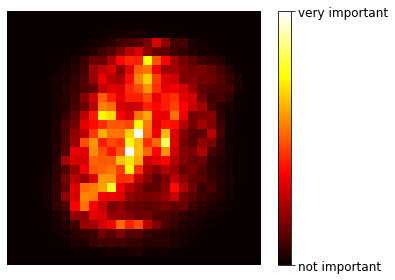

In [24]:
plot_digit(rnd_clf.feature_importances_)

cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(),rnd_clf.feature_importances_.max()])
#오른쪽 컬러바
cbar.ax.set_yticklabels(["not important","very important"])

save_fig("mnist_feature_importance_plot")

plt.show()

# 7.5 부스팅

#### 7.5.1 에이다부스트 (adaptive boosting)

In [25]:
#약한 학습기를 여러개 연결하여 강한 학습기를 만듦.
#이전 모델이 과소적합(오류)했던 훈련샘플의 가중치를 높이는것.
#해당 예측기의 에러율로 가중치를 구하고, 그 가중치를 고려해 훈련샘플의 가중치를 업데이트

from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
DecisionTreeClassifier(max_depth=1),n_estimators=200,
    algorithm = "SAMME.R", learning_rate=0.5
    
    
    #SAMMME.R 은 predict_proba를 지원하는 모델일때.
)

ada_clf.fit(X_train,y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=200)

## 7.5.2 그레디언트 부스팅

In [26]:
#adaboost --> 샘플의 가중치 업데이트
#gradient boost --> 이전 모델의 잔차를 학습

In [27]:
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

#### 직접 GBRT 만들어보기

In [28]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2)
tree_reg1.fit(X,y)

DecisionTreeRegressor(max_depth=2)

In [29]:
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(max_depth=2, random_state=42)

In [30]:
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2,random_state=42)
tree_reg3.fit(X,y3)

DecisionTreeRegressor(max_depth=2, random_state=42)

In [31]:
X_new = np.array([[0.8]])

In [32]:
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1,tree_reg2,tree_reg3))

In [33]:
y_pred

array([0.75026781])

#### GBRT사용법

In [34]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2,n_estimators=3,learning_rate=1.0, random_state=42)
gbrt.fit(X,y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3,
                          random_state=42)

#### 조기 종료를 사용한 그레디언트 부스팅

In [35]:
#learning_rate는 각 트리의 기여정도를 정함.
#낮으면 많은 트리가 필요해지지만 성능은좋아짐.

#트리가 너무 많으면 과소적합. 많으면 과대적합 가능.

#최적의 트리 수를 정하기 위해 earlystoping 사용


import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train,X_val,y_train,y_val = train_test_split(X,y,random_state=49)

#트리를 여러개 만들어놓음
gbrt =GradientBoostingRegressor(max_depth=2,n_estimators=120,random_state=42)
gbrt.fit(X_train,y_train)


errors =[mean_squared_error(y_val,y_pred) 
        for y_pred in gbrt.staged_predict(X_val)]
#staged_predict를 통해 각 학습단계(트리 수) 마다 모든 예측기를 순회하며 점수계산
#여기선 mse
#ex) 2개일떄 1~2 순회. 예측 -->점수 
#3개일때 1~3순회. 예측 --> 점수
#4개일떄 1~4순회. 예측 --> 점수

bst_n_estimators =np.argmin(errors) + 1
gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators , random_state=42)
gbrt_best.fit(X_train,y_train)


GradientBoostingRegressor(max_depth=2, n_estimators=56, random_state=42)

In [36]:
min_error = np.min(errors)

In [37]:

#트리를 여러개 훈련시켜놓지않고
#훈련을 중지하는 방법도 가능. warm_start=True로 하여 기존 트리를 유지하면서 훈련을 추가

gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True,random_state=42)

min_val_error = float("inf")
error_going_up = 0

for n_estimators in range(1,120):
    gbrt.n_estimators=n_estimators
    gbrt.fit(X_train,y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val,y_pred)
    
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up +=1
        if error_going_up==5:
            break
    #다섯번 연속으로 에러가 오르면 early stopping


In [38]:
print(gbrt.n_estimators)

61


In [39]:
print("minumum validation MSE :", min_val_error)

minumum validation MSE : 0.002712853325235463


#### XGBOOST

In [54]:
import xgboost

#익스트림 그레디언트 부스팅

In [50]:
xgb_reg = xgboost.XGBRegressor(random_state=42)
xgb_reg.fit(X_train,y_train)
y_pred = xgb_reg.predict(X_val)
val_error = mean_squared_error(y_val, y_pred)
print("Validation MSE: ",val_error)

Validation MSE:  0.004000408205406276


In [52]:
xgb_reg.fit(X_train, y_train,
                eval_set=[(X_val, y_val)], early_stopping_rounds=2)
y_pred = xgb_reg.predict(X_val)                                                                                        
val_error = mean_squared_error(y_val, y_pred)  # 책에 없음
print("Validation MSE:", val_error)            # 책에 없음

[0]	validation_0-rmse:0.22834
[1]	validation_0-rmse:0.16224
[2]	validation_0-rmse:0.11843
[3]	validation_0-rmse:0.08760
[4]	validation_0-rmse:0.06848
[5]	validation_0-rmse:0.05709
[6]	validation_0-rmse:0.05297
[7]	validation_0-rmse:0.05129
[8]	validation_0-rmse:0.05155
Validation MSE: 0.002630868681577655


# 연습문제 8

#### 문제: MNIST 데이터를 불러들여 훈련 세트, 검증 세트, 테스트 세트로 나눕니다(예를 들면 훈련에 40,000개 샘플, 검증에 10,000개 샘플, 테스트에 10,000개 샘플).

In [55]:
from sklearn.model_selection import train_test_split

X_train_val,X_test,y_train_val,y_test = train_test_split(
mnist.data, mnist.target,test_size = 10000, random_state=42
)

X_train,X_val,y_train,y_val = train_test_split(
X_train_val,y_train_val,test_size=10000,random_state=42
)


#### 문제: 그런 다음 랜덤 포레스트 분류기, 엑스트라 트리 분류기, SVM 같은 여러 종류의 분류기를 훈련시킵니다.

In [59]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier

random_forest_clf = RandomForestClassifier(n_estimators=100,random_state=42)
extra_tree_clf = ExtraTreesClassifier(n_estimators=100,random_state=42)
svm_clf = LinearSVC(random_state=42)
mlp_clf = MLPClassifier(random_state=42)

In [61]:
estimators =[random_forest_clf,extra_tree_clf,svm_clf,mlp_clf]
for estimator in estimators:
    print("Training the",estimator)
    estimator.fit(X_train,y_train) 

Training the RandomForestClassifier(random_state=42)
Training the ExtraTreesClassifier(random_state=42)
Training the LinearSVC(random_state=42)


C:\Users\9sup2\anaconda3\envs\env\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Training the MLPClassifier(random_state=42)


In [62]:
[estimator.score(X_val,y_val) for estimator in estimators]

[0.9692, 0.9715, 0.8695, 0.9606]

#### svm은 다른 분류기에 비해 성능이 떨어짐 하지만, voting에 도움을 줄수도 있으니 넣어봄

#### 문제: 그리고 검증 세트에서 개개의 분류기보다 더 높은 성능을 내도록 이들을 간접 또는 직접 투표 분류기를 사용하는 앙상블로 연결해보세요.

In [64]:
from sklearn.ensemble import VotingClassifier

In [65]:
named_estimators = [
    ("random_forest_clf",random_forest_clf),
    ("extra_tree_clf",extra_tree_clf),
    ("svm_clf",svm_clf),
    ("mlp_clf",mlp_clf)
]


In [66]:
voting_clf = VotingClassifier(named_estimators)

In [67]:
voting_clf.fit(X_train,y_train)

C:\Users\9sup2\anaconda3\envs\env\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


VotingClassifier(estimators=[('random_forest_clf',
                              RandomForestClassifier(random_state=42)),
                             ('extra_tree_clf',
                              ExtraTreesClassifier(random_state=42)),
                             ('svm_clf', LinearSVC(random_state=42)),
                             ('mlp_clf', MLPClassifier(random_state=42))])

In [68]:
voting_clf.score(X_val,y_val)

0.97

In [69]:
[estimator.score(X_val,y_val) for estimator in voting_clf.estimators_]

[0.9692, 0.9715, 0.8695, 0.9606]

#### SVM 모델을 제거하면 더 좋아지는지 확인. 
다음과 같이 set_params()를 사용하여 None으로 지정하면 특정 예측기를 제외시킬 수 있습니다:

In [70]:
voting_clf.set_params(svm_clf=None)

VotingClassifier(estimators=[('random_forest_clf',
                              RandomForestClassifier(random_state=42)),
                             ('extra_tree_clf',
                              ExtraTreesClassifier(random_state=42)),
                             ('svm_clf', None),
                             ('mlp_clf', MLPClassifier(random_state=42))])

In [73]:
voting_clf.estimators
#예측기 목록 확인

[('random_forest_clf', RandomForestClassifier(random_state=42)),
 ('extra_tree_clf', ExtraTreesClassifier(random_state=42)),
 ('svm_clf', None),
 ('mlp_clf', MLPClassifier(random_state=42))]

In [72]:
voting_clf.estimators_
#훈련된 예측기엔 아직 svm이 있음.

[RandomForestClassifier(random_state=42),
 ExtraTreesClassifier(random_state=42),
 LinearSVC(random_state=42),
 MLPClassifier(random_state=42)]

In [74]:
del voting_clf.estimators_[2]
#훈련된 목록에서도 삭제완료.(다시 학습해도 사라짐)

In [75]:
voting_clf.score(X_val,y_val)
#0.97 --> 0.9737

0.9737

#### 훨씬 나아졌네요! SVM 모델이 성능을 저하시켰습니다. 이제 간접 투표 분류기를 사용해 보죠. 분류기를 다시 훈련시킬 필요는 없고 voting을 "soft"로 지정하면 됩니다:

In [77]:
voting_clf.voting="soft"

In [78]:
voting_clf.score(X_val,y_val)

0.97

In [79]:
#직접이 더 좋았음.(hard)

#### 테스트 세트로 확인해보세요. 개개의 분류기와 비교해서 성능이 얼마나 향상되나요?

In [80]:
voting_clf.voting= "hard"
voting_clf.score(X_test,y_test)

0.9711

In [91]:
[estimator.score(X_test,y_test) for estimator in voting_clf.estimators_]

[0.9645, 0.9691, 0.9586]

In [92]:
#voting이 조금이라도 더 좋았음.

# 연습문제 9 : 스태킹 앙상블

#### 문제: 이전 연습문제의 각 분류기를 실행해서 검증 세트에서 예측을 만들고 그 결과로 새로운 훈련 세트를 만들어보세요. 각 훈련 샘플은 하나의 이미지에 대한 전체 분류기의 예측을 담은 벡터고 타깃은 이미지의 클래스입니다. 새로운 훈련 세트에 분류기 하나를 훈련시켜 보세요.

In [93]:
estimators

MLPClassifier(random_state=42)

In [95]:
estimators = [random_forest_clf, extra_tree_clf, svm_clf, mlp_clf]

In [98]:
X_val_predictions = np.empty((len(X_val), len(estimators)), dtype=np.float32)
print(X_val_predictions.shape) #10000,4

for index, estimator in enumerate(estimators):
    X_val_predictions[:, index] = estimator.predict(X_val)
    

(10000, 4)


In [99]:
X_val_predictions

array([[5., 5., 5., 5.],
       [8., 8., 8., 8.],
       [2., 2., 2., 2.],
       ...,
       [7., 7., 7., 7.],
       [6., 6., 6., 6.],
       [7., 7., 7., 7.]], dtype=float32)

#### 예측결과값으로 블랜더 학습

In [100]:
rnd_forest_blender = RandomForestClassifier(n_estimators=200,oob_score=True,random_state=42)
rnd_forest_blender.fit(X_val_predictions,y_val)
#타겟은 그대로

RandomForestClassifier(n_estimators=200, oob_score=True, random_state=42)

In [101]:
rnd_forest_blender.oob_score_

0.9704

#### 
이 블렌더를 세밀하게 튜닝하거나 다른 종류의 블렌더(예를 들어, MLPClassifier)를 시도해 볼 수 있습니다. 그런 늘 하던대로 다음 교차 검증을 사용해 가장 좋은 것을 선택합니다.

#### 테스트 세트에 앙상블을 평가

In [102]:
X_test_predictions = np.empty((len(X_test),len(estimators)),dtype = np.float32)

for index,estimator in enumerate(estimators):
    X_test_predictions[:,index] = estimator.predict(X_test)

In [103]:
y_pred = rnd_forest_blender.predict(X_test_predictions)

In [109]:
rnd_forest_blender.score(X_test_predictions,y_test)
#얘로도 가능하고 metrics.accuracy_score 도 가능

0.9688

In [110]:
from sklearn.metrics import accuracy_score

In [111]:
accuracy_score(y_test,y_pred)

0.9688

#### 이 스태킹 앙상블은 앞서 만든 투표 기반 분류기만큼 성능을 내지는 못합니다. 최선의 개별 분류기만큼 뛰어나지는 않습니다.